In [1]:
from transformers import LlamaForCausalLM, LlamaTokenizer, LlamaConfig
import sys
import time
import random
import pickle
import math
import argparse
import os
import torch
import numpy as np

import sys
sys.path.append('/home/haokunliu/past-interaction-learning/code')
from prompt import PROMPT_DICT
from data_loader import get_train_data, get_data
from experiments.hypotheses_generation_batched import *

In [2]:
model = 'Llama-2-7b-chat'
args = {
    'cache_dir': "/net/scratch/haokunliu/llama_cache",
    'path_name': "/net/projects/veitch/LLMs/llama2-based-models/llama2-hf/"+model+"-hf/"
}

api = LLMWrapper(model,**args)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/haokunliu/miniconda3/envs/LLMs-new/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/haokunliu/miniconda3/envs/LLMs-new/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [3]:
num_test = 100
train_sizes = [1,3,6,12,25,50,100]
SEEDS = [1,2,3]
num_hypothesis = 5
best_hypotheses_all = []
test_accs = []

for num_train in train_sizes:
    best_hypotheses = []
    test_acc_trial = 0
    for SEED in SEEDS:
        test_pred,test_acc,best_hypothesis = run_inference(api,'shoe',num_train,num_test,num_hypothesis)
        best_hypotheses.append(best_hypothesis)
        test_acc_trial += test_acc
    test_accs.append(test_acc_trial/len(SEEDS))
    best_hypotheses_all.append(best_hypotheses)

task_name: shoe
******* information_prompt *******
The customer's appearance: a old and tall man with white hat, red shirt, and a small white bag. The customer bought a pair of red shoes.

**********************************
******* information_prompt *******
The customer's appearance: a young and short man with white hat, white shirt, and a small red bag. The customer bought a pair of white shoes.

**********************************
******* information_prompt *******
The customer's appearance: a young and tall man with orange hat, black shirt, and a large blue bag. The customer bought a pair of black shoes.

**********************************
******* information_prompt *******
The customer's appearance: a old and short woman with black hat, orange shirt, and a large white bag. The customer bought a pair of orange shoes.

**********************************
******* information_prompt *******
The customer's appearance: a old and tall woman with black hat, white shirt, and a large blue bag

/home/haokunliu/miniconda3/envs/inductive-reasoning/lib/python3.7/site-packages/transformers/generation/utils.py:1260: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"


******* hypothesis_based_inference_without_reasoning *******
###
Instruction:
You are a shoe salesman and want to recommend shoes to customers. There are white, red, orange, green, blue, and black shoes.
From past experiences, you learned some patterns. 
Now, at each time, you should apply a learned pattern to a new customer and recommend a shoe color.
Give an answer for the shoe color recommendation. The answer should be one color word. It has to be one of white, red, orange, green, blue, and black.
###

Pattern: The color of the shoes purchased is influenced by the age and height of the customer, with older and taller customers more likely to choose white shoes.

New customer: a old and tall man with white hat, red shirt, and a small white bag is buying a pair of shoes, the shoes should be which color?

Answer: 
************************************************************
******* hypothesis_based_inference_without_reasoning *******
###
Instruction:
You are a shoe salesman and want to

Text(0.5, 1.0, 'Shoe dataset, bached version, Llama-2-chat-7b')

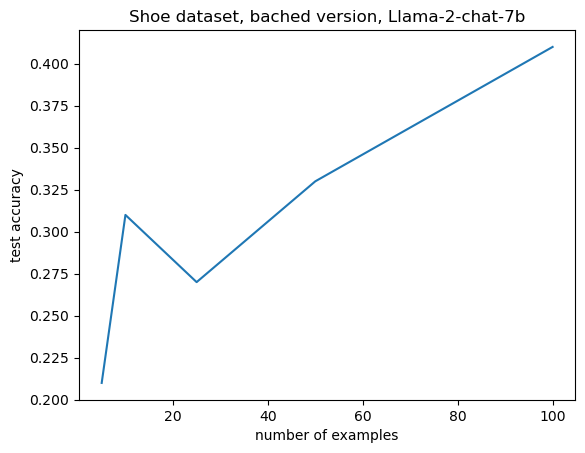

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_sizes,test_accs)
plt.xlabel("number of examples")
plt.ylabel("test accuracy")
plt.title("Shoe dataset, bached version, Llama-2-chat-7b")

In [8]:
gpt = LLMWrapper(model='turbo35_0613')

In [9]:
_, test_data = get_data('shoe',200,100)

task_name: shoe


In [10]:
gpt_preds = []
gpt_accs = []
for hypothesis in best_hypotheses:
    pred = hypothesis_pred(gpt,hypothesis,test_data)
    acc = compute_acc(pred,test_data['label'])
    gpt_preds.append(pred)
    gpt_accs.append(acc)

******* hypothesis_based_inference_without_reasoning *******
###
Instruction:
You are a shoe salesman and want to recommend shoes to customers. There are white, red, orange, green, blue, and black shoes.
From past experiences, you learned some patterns. 
Now, at each time, you should apply a learned pattern to a new customer and recommend a shoe color.
Give an answer for the shoe color recommendation. The answer should be one color word. It has to be one of white, red, orange, green, blue, and black.
###

Pattern: The color of the shoes purchased is influenced by the age and height of the customer, with older and taller customers more likely to choose white shoes.

New customer: a young and tall woman with white hat, blue shirt, and a small orange bag is buying a pair of shoes, the shoes should be which color?

Answer: 
************************************************************
******* hypothesis_based_inference_without_reasoning *******
###
Instruction:
You are a shoe salesman and w

Text(0.5, 1.0, 'Shoe dataset, bached version, gpt-3.5-turbo-0613')

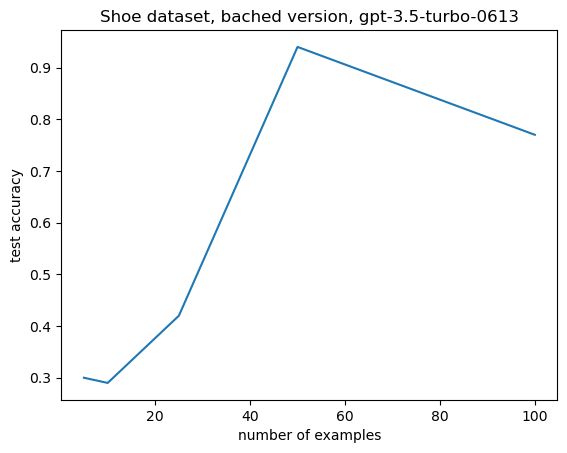

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_sizes,gpt_accs)
plt.xlabel("number of examples")
plt.ylabel("test accuracy")
plt.title("Shoe dataset, bached version, gpt-3.5-turbo-0613")

In [6]:
num_test = 100
train_sizes = [1,3,6,12,25,50,100]
SEEDS = [1,2,3]
test_accs = []
# hypothesis = "The customer's appearance indicates that they will buy shoes of the same color as their shirt."
hypothesis = None
for num_train in train_sizes:
    test_acc_trial = 0
    for SEED in SEEDS:
        train_data,test_data = get_data('shoe',num_train,num_test)
        test_pred = few_shot_pred(api,hypothesis,train_data,test_data)
        test_acc = compute_acc(test_pred,test_data['label'])
        test_acc_trial += test_acc
    test_accs.append(test_acc_trial/len(SEEDS))

task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe
task_name: shoe


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


task_name: shoe
task_name: shoe


Text(0.5, 1.0, 'Shoe dataset, few-shot without hypothesis, Llama-2-7b-chat')

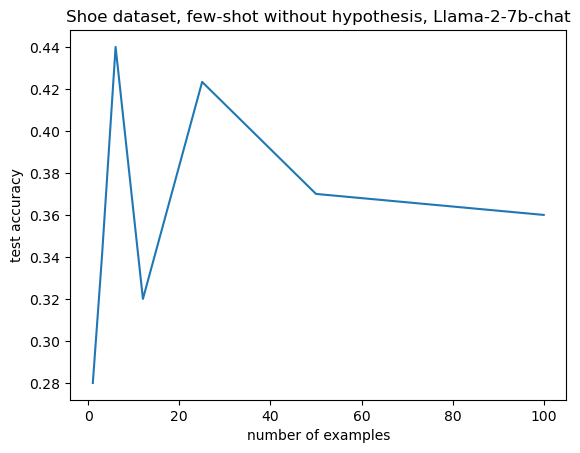

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_sizes,test_accs)
plt.xlabel("number of examples")
plt.ylabel("test accuracy")
plt.title("Shoe dataset, few-shot without hypothesis, "+model)